# Object Detection Demo


## Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from io import BytesIO
from typing import Iterable

import numpy as np
import requests
import torch as tr
from PIL import Image
from hydra_zen import instantiate

from jatic_toolbox.interop.huggingface.configs import create_huggingface_model_config
from jatic_toolbox.interop.smqtk.configs import create_smqtk_model_config
from jatic_toolbox.protocols.array import ArrayLike
from jatic_toolbox.protocols.object_detection import ObjectDetection, ObjectDetectionOutput
from jatic_toolbox.protocols.object_detection import BoundingBox


## Object Detection Pipeline

Here we define a simple detection pipeline using `jatic_toolbox.protocols`. 

In [2]:
def eval_image_detector(
    detector: ObjectDetection, img_iter: Iterable[ArrayLike], threshold: float = 0.4
) -> Iterable[ObjectDetectionOutput]:
    """Evalulator for Object Detection Models.

    Parameters
    ----------
    detector: ImageDetector
    img_iter: Iterable[ArrayLike]
    threshold: float = 0.4

    Returns
    -------
    DetectorOutput
    """
    output = detector(img_iter)

    threshold_output = []
    for dets in output:
        boxes_threshold = []
        scores_threshold = []
        for i, (boxes, score_dict) in enumerate(zip(dets.boxes, dets.scores)):
            if threshold > 0.0:
                cls_idx = max(score_dict, key=score_dict.get)
                conf = score_dict[cls_idx]

                if conf >= threshold:
                    boxes_threshold.append(boxes)
                    scores_threshold.append({cls_idx: conf})
            else:
                boxes_threshold.append(boxes)
                scores_threshold.append(score_dict)

        threshold_output.append(
            ObjectDetectionOutput(boxes=boxes_threshold, scores=scores_threshold)
        )
    return threshold_output


## Example Image

(-0.5, 959.5, 539.5, -0.5)

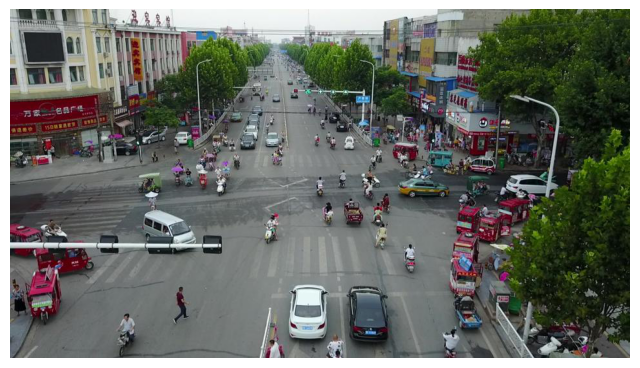

In [3]:
url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img = np.asarray(img_pil)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")


## Create Configurations

First define the SMQTK CenterNet configurations:

In [4]:
jatic_configs = create_smqtk_model_config()
jatic_configs["model"]

{('model', 'smqtk__centernet-resnet50'): types.Builds_CenterNetVisdrone,
 ('model', 'smqtk__centernet-resnet18'): types.Builds_CenterNetVisdrone,
 ('model', 'smqtk__centernet-res2net50'): types.Builds_CenterNetVisdrone}

For HuggingFace, our configuration creator allows filtering on models using the `huggingface_hub` API.  Here we filter for PyTorch implementations of object detection using DETR.

In [5]:
from huggingface_hub import (
    HfApi,
    ModelFilter,
    ModelSearchArguments,
)

api = HfApi()
model_args = ModelSearchArguments()

filt = ModelFilter(
    task=model_args.pipeline_tag.ObjectDetection,
    model_name="detr",
    library=model_args.library.PyTorch,
    
)

jatic_configs = create_huggingface_model_config(filter=filt)

/home/justin_goodwin/.conda/envs/raise/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:233: FutureWarning: 'list_models' currently returns a list of objects but is planned to be a generator starting from version 0.14 in order to implement pagination. Please avoid to use `list_models(...).__len__` or explicitly convert the output to a list first with `list(iter(list_models)(...))`.
  warnings.warn(self._deprecation_msg.format(attr_name=attr_name), FutureWarning)


In [6]:
jatic_configs

jatic-interop
{'model': ['smqtk__centernet-resnet50', 'smqtk__centernet-resnet18', 'smqtk__centernet-res2net50', 'davanstrien__detr_beyond_words', 'facebook__detr-resnet-101-dc5', 'facebook__detr-resnet-101', 'facebook__detr-resnet-50-dc5', 'facebook__detr-resnet-50', 'hf-internal-testing__tiny-detr-mobilenetsv3', 'SenseTime__deformable-detr-single-scale-dc5', 'SenseTime__deformable-detr-single-scale', 'SenseTime__deformable-detr-with-box-refine-two-stage', 'SenseTime__deformable-detr-with-box-refine', 'SenseTime__deformable-detr', 'nielsr__detr-resnet-50-new', 'nielsr__detr-resnet-50', 'TahaDouaji__detr-doc-table-detection', 'gary109__STAS_detr-resnet-50', 'Jackett__detr_test', 'biglam__detr-resnet-50_fine_tuned_nls_chapbooks', 'nickmuchi__detr-resnet50-finetuned-license-plate-detection', 'nickmuchi__detr-resnet50-license-plate-detection', 'nielsr__detr-table-detection', 'nielsr__detr-table-structure-recognition', 'microsoft__conditional-detr-resnet-50', 'SalML__DETR-table-detection',

In [7]:
jatic_configs[("model", 'smqtk__centernet-resnet50')]

types.Builds_CenterNetVisdrone

### Evaluate and Plot

In [8]:
def show_dets(ax, dets: ObjectDetectionOutput):
    for i, (bbox, score_dict) in enumerate(zip(dets.boxes, dets.scores)):
        cls_idx = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_idx]

        x1, y1 = bbox.min_vertex
        x2, y2 = bbox.max_vertex
        ax.add_patch(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
        )


Loading URL: https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download
Launching run on smqtk__centernet-resnet50


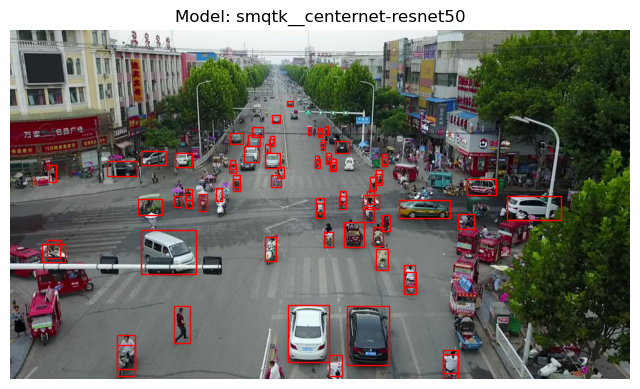

In [9]:
obj_det= "smqtk__centernet-resnet50"
 
print(f"Loading URL: {url}")
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img = np.asarray(img_pil)

print(f"Launching run on {obj_det}")

model = instantiate(jatic_configs["model", obj_det])
dets = eval_image_detector(model, [img], threshold=0.4)

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Model: {obj_det}")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets[0])

## User Interface with IPyWidgets

An example of creating a UI with `hydra-zen` and the object detection interface.

In [10]:
from ipywidgets import widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output



models = [k[1] for k in jatic_configs["model"].keys()]
obj_det = widgets.Dropdown(
    options=models,
    value=models[0],
    description='Object Detectors:',
    layout=widgets.Layout(width="max-content")
)

button = widgets.Button(description="Launch!", layout=widgets.Layout(margin="30px"))
output = widgets.Output()

display(obj_det, button, output)

def on_button_clicked(b):
    with output:
        if len(obj_det.value) > 0:
            clear_output()

            print(f"Loading URL: {url}")
            response = requests.get(url)
            img_pil = Image.open(BytesIO(response.content))
            img = np.asarray(img_pil)

            print(f"Launching run on {obj_det.value}")

            model = instantiate(jatic_configs["model", obj_det.value])
            dets = eval_image_detector(model, [img], threshold=0.4)

            fig, axs = plt.subplots(figsize=(8, 8))
            axs.set_title(f"Model: {obj_det.value}")
            axs.imshow(img)
            axs.axis("off")
            show_dets(axs, dets[0])
            show_inline_matplotlib_plots()
        else:
            print(f"Please select a model")

button.on_click(on_button_clicked)

Dropdown(description='Object Detectors:', layout=Layout(width='max-content'), options=('smqtk__centernet-resne…

Button(description='Launch!', layout=Layout(margin='30px'), style=ButtonStyle())

Output()